# Loading Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Preprocessing all 3 datasets of all 3 sectors

### Managing seasonal and cyclic effects

In [2]:
def manage_seasonal_cyclic(df):
    # Seasonal decomposition
    decomposition = seasonal_decompose(df, model='additive', period=12)  # Assuming monthly data
    seasonal = decomposition.seasonal
    df_corrected = df - seasonal
    return df_corrected

### Finance Sector

In [3]:
finance_df = pd.read_csv("./Dataset/Monthly.csv")
finance_df['Date'] = pd.to_datetime(finance_df['Date'])
finance_df.drop_duplicates(inplace=True)
finance_df.fillna(method='ffill', inplace=True)
finance_df['close'] = manage_seasonal_cyclic(finance_df['close'])


### Energy Sector

In [4]:
energy_df = pd.read_csv("./Dataset/Hourly.csv")
energy_df['Datetime'] = pd.to_datetime(energy_df['Datetime'])
energy_df.drop_duplicates(inplace=True)
energy_df.fillna(method='ffill', inplace=True)
energy_df['AEP_MW'] = manage_seasonal_cyclic(energy_df['AEP_MW'])

### Environmental Sector

In [5]:
environment_df = pd.read_csv("./Dataset/Daily.csv")
environment_df['date'] = pd.to_datetime(environment_df['date'])
environment_df.drop_duplicates(inplace=True)
environment_df.fillna(method='ffill', inplace=True)
environment_df['value'] = manage_seasonal_cyclic(environment_df['value'])

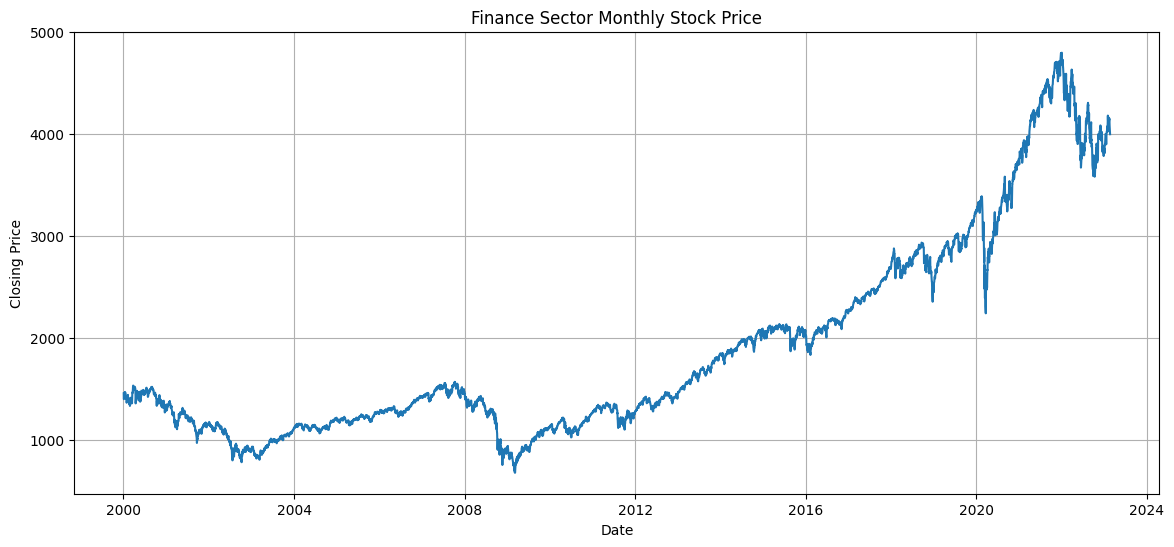

In [6]:
# Visualizing Finance sector
plt.figure(figsize=(14, 6))
plt.plot(finance_df['Date'], manage_seasonal_cyclic(finance_df['close']))
plt.title('Finance Sector Monthly Stock Price')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)
plt.show()

# Visualizing Energy sector
plt.figure(figsize=(14, 6))
plt.plot(energy_df['Datetime'], manage_seasonal_cyclic(energy_df['AEP_MW']))
plt.title('Energy Sector Hourly Energy Consumption')
plt.xlabel('Datetime')
plt.ylabel('Energy Consumption (MW)')
plt.grid(True)
plt.show()

# Visualizing Environmental sector
plt.figure(figsize=(14, 6))
plt.plot(environment_df['date'], manage_seasonal_cyclic(environment_df['value']))
plt.title('Environmental Sector Daily CO2 Concentrations')
plt.xlabel('Date')
plt.ylabel('CO2 Concentration')
plt.grid(True)
plt.show()


In [ ]:
finance_df, energy_df, environment_df

,Date,open,high,low,close
0,2000-01-03,1469.25,1478.00,1438.36,1453.793647
1,2000-01-04,1455.22,1455.22,1397.43,1396.463452
2,2000-01-05,1399.42,1413.27,1377.68,1400.027038
3,2000-01-06,1402.11,1411.90,1392.10,1401.960166
4,2000-01-07,1403.45,1441.47,1400.73,1439.999199
...,...,...,...,...,...
5816,2023-02-14,4126.70,4159.77,4095.01,4137.659977
5817,2023-02-15,4119.50,4148.11,4103.98,4150.058111
5818,2023-02-16,4114.75,4136.54,4089.49,4091.735815
5819,2023-02-17,4077.73,4081.51,4047.95,4078.211219


# Model Development

### Arima

In [ ]:
# Function to check the stationarity of the data
def check_stationarity(data):
    result = adfuller(data)
    if result[1] <= 0.05:
        return True, result[0]
    else:
        return False, result[0]

# Function to difference the data and determine the order of differencing (d)
def difference_data(data):
    d = 0
    stationary = False
    while not stationary:
        stationary, adf_statistic = check_stationarity(data)
        if not stationary:
            d += 1
            data = data.diff().dropna()  # Difference the data
    return data, d

# Stationarize finance sector data
finance_stationary, d_finance = difference_data(finance_df['close'])
print("Differencing order for finance sector data:", d_finance)

# Stationarize environmental sector data
environment_stationary, d_environment = difference_data(environment_df['value'])
print("Differencing order for environmental sector data:", d_environment)

Differencing order for finance sector data: 1
Differencing order for environmental sector data: 1


In [ ]:
# Function to evaluate ARIMA model
def evaluate_arima_model(data, order):
    train_size = int(len(data) * 0.8)
    train, test = data.iloc[:train_size], data.iloc[train_size:]  # Use iloc for integer-based indexing
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=order)
        try:
            model_fit = model.fit()
            yhat = model_fit.forecast()[0]
            predictions.append(yhat)
            history.append(test.iloc[t])  # Append test data
        except Exception as e:
            print(f'Error occurred: {e}')
            continue
    error = mean_squared_error(test, predictions)
    return error

# Function to find the best ARIMA model parameters
def find_best_arima_parameters(data, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(data, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print(f'ARIMA{order} MSE={mse}')
                except:
                    continue
    print(f'Best ARIMA{best_cfg} MSE={best_score}')
    return best_cfg

# Example usage
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)


best_cfg_finance = find_best_arima_parameters(finance_stationary, p_values, d_values, q_values)
best_cfg_energy = find_best_arima_parameters(energy_df['AEP_MW'], p_values, d_values, q_values)
best_cfg_environment = find_best_arima_parameters(environment_stationary, p_values, d_values, q_values)



ARIMA(0, 0, 0) MSE=2142.256568654966


In [ ]:
print(best_cfg_finance)
print(best_cfg_energy)

NameError: name 'best_cfg_finance' is not defined